# Description of Script
This script illustrates a basic EDA of the pharmacy visit dataset and creates the IIT outcome variable

**Author:** Marang Mutloatse

**Version:** 0.0.1

**State:** Development

## Import Libraries

In [2]:
import pandas as pd
import datetime as dt
import warnings
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import math
import glob
import os
user_dev_path = os.path.dirname(os.getcwd())
# get parent path for package
package_path = os.path.dirname(user_dev_path)
import sys
sys.path.insert(0,package_path + '/src/')
import yaml
from hiv_support_package import visit_features,target_creation
from datetime import timedelta
plt.style.use('fivethirtyeight')
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

## Working Functions

In [4]:
def load_excel_sheet(path: str):
    if path is not None:
        try:
            xls = pd.ExcelFile(path)
            df = xls.parse(skiprows=0)
            return df
        except Exception as e:
            print(f"Exception on loading excel spreadsheet with error: {e}")

def convert_to_datetime(df,date_col: str):
    if df is not None:
        try:
            df[date_col] = pd.to_datetime(df[date_col],errors='coerce')
            return df
        except Exception as e:
            print(f"Exception on converting to datetime with error: {e}") 
            
def print_num_rows_cols(df, df_name: str):
        if df is not None:
            return print(f"{df_name} data has {df.shape[1]} columns and {df.shape[0]} rows.") 

def check_null_values(df):
    if df is not None:
        try:
            missing_value = df.isnull().sum()
            mis_val_percent = 100 * df.isnull().sum() / len(df)
            mis_val_table = pd.concat([missing_value, mis_val_percent], axis=1)
            mis_val_table_rename_cols = mis_val_table.rename(
                columns={0: "Missing Values", 1: "% of Total Values"}
            )
            mis_val_table_rename_cols = (
                mis_val_table_rename_cols[mis_val_table_rename_cols.iloc[:, 1] != 0]
                .sort_values("% of Total Values", ascending=False)
                .round(1)
            )
            print(
                "There are "
                + str(mis_val_table_rename_cols.shape[0])
                + " columns that have missing values"
            )
            return mis_val_table_rename_cols
        except Exception as e:
            print(f"Exception on checking missing values with error: {e}")

def under_represented(df, threshold=0.99):
    under_rep = []
    for column in df:
        counts = df[column].value_counts()
        majority_freq = counts.iloc[0]
        if (majority_freq / len(df)) > threshold:
            under_rep.append(column)
        if not under_rep:
            print("No underrepresented features")
        else:
            if TARGET in under_rep:
                print("The target variable is underrepresented, consider rebalancing")
                under_rep.remove(TARGET)
            print(str(under_rep) + " underrepresented")
        return under_rep

def categorical_bar_plot(df):
    if df is not None:
        for i in df.columns[df.dtypes==object]:
            df[i].value_counts().plot(kind='bar')
            plt.title(i)
            plt.show()
            
def plot_line_graph(df,x_variable: str,y_variable: str,x_label: str,y_label: str):
    ax = sns.lineplot(x = x_variable,y=y_variable,data=df)
    ax.set(xlabel=x_label, ylabel=y_label)
    ax.set_title('Comparison Plot: Trend of Average Monthly LTFU')
    plt.xticks(rotation=60)
    plt.legend(loc='upper left')
    sns.set(rc={'figure.figsize':(10,10)})

def plot_boxplot_graph(df,x_variable: str,y_variable: str,x_label: str,y_label: str,title: str,hue=None):
    ax = sns.boxplot(x = x_variable,y=y_variable,data=df,hue=None)
    ax.set(xlabel=x_label, ylabel=y_label)
    ax.set_title(title)
    plt.xticks(rotation=60)
    plt.legend(loc='upper left')
    sns.set(rc={'figure.figsize':(10,10)})

## Loading Data

In [2]:
user_dev_path = os.path.dirname(os.getcwd())

try: 
    with open (user_dev_path + '/' + 'config_LTFU.yaml', 'r') as file:
        config = yaml.safe_load(file)
except Exception as e:
    print(f'Error reading the config file, {e}')

In [15]:
# Data path/folder on local machine
input_root = config['rise_files']['raw_data_path']

# Pharmacy files
pharmacy_file = config['rise_files']['merged_pharmacy_file']
pharmacy_input = input_root + pharmacy_file

# Inclusion criteria
start_date = config['ltfu_inclusion_criteria']['art_start_date']
LAST_EXPECTED_VISIT = config['ltfu_inclusion_criteria']['last_expected_visit']

print(f"This is the pharmacy data's input path is: {pharmacy_input}\n")
print(f"Start date is: {start_date}\n")
print(f"Last Expected Visit date is: {LAST_EXPECTED_VISIT}\n")

This is the pharmacy data's input path is: /data/rise_data/pharmacy_merged.csv

Start date is: 2010-01-01 00:00:00

Last Expected Visit date is: 2020-12-31 00:00:00



In [16]:
%%time
df = pd.read_csv(pharmacy_input,low_memory=False)

CPU times: user 34.7 s, sys: 3.11 s, total: 37.8 s
Wall time: 47.9 s


## Filter For ART

In [17]:
ART_LIST = ['ART First Line Adult','ART Second Line Adult','ART First Line Children','ART Second Line Children','Third Line']
df = df[df['Regimen Line'].isin(ART_LIST)]

In [18]:
print("These are the counts for the different Regimen Lines after filtering:")
df['Regimen Line'].value_counts()

These are the counts for the different Regimen Lines after filtering:


ART First Line Adult        2490734
ART First Line Children       78773
ART Second Line Adult         41530
ART Second Line Children       2232
Third Line                      138
Name: Regimen Line, dtype: int64

### Filter Current Status

In [19]:
current_status_list = ["Art Transfer Out",
"Known Death",
"Hiv+ Non Art",
"Art Transfer Out",
"Hiv Exposed Status Unknown",
"Hiv Exposed Infant Status Unknown",
"Pre-Art Transfer Out",
"Hiv Exposed Infant Status Unknown"]

In [20]:
df = df[~df['P_CURRENT_STATUS'].isin(current_status_list)]

In [21]:
df.P_CURRENT_STATUS.value_counts()

Art Start                             1782214
Art Restart                            356149
Lost To Follow Up                      128288
Art Transfer In                        111023
Stopped Treatment                       16439
Art Start - External                     1432
Hiv Exposed Infant Status Negative        163
Pre-Art Transfer In                        28
Hiv Negative                               21
Name: P_CURRENT_STATUS, dtype: int64

In [27]:
df = df[df['P_DATE_BIRTH'].notna()]

## Data Description and Verification

In [28]:
print_num_rows_cols(df,'Pharmacy Data')

Pharmacy Data data has 49 columns and 2173290 rows.


In [29]:
pd.set_option('display.max_columns', 500)
df = df.sort_values(by=['PATIENT_ID','DATE_VISIT'])

In [30]:
print("Shape before cleaning by date: ")
print_num_rows_cols(df,'Pharmacy')

df['DATE_VISIT'] = pd.to_datetime(df['DATE_VISIT'], errors='coerce')
df['NEXT_APPOINTMENT'] = pd.to_datetime(df['NEXT_APPOINTMENT'], errors='coerce')

# Prescription finish Date Timeline
df['EF_MEDS_CONSUMED_DATE'] = df['DATE_VISIT']+pd.to_timedelta(df['DURATION'],unit='d')

df = df.loc[(df['DATE_VISIT'] >= '1998-01-01 00:00:00') & (df['DATE_VISIT'] <= '2020-12-31 00:00:00')]

print(" ")
print("Shape after limiting by date: ")
print_num_rows_cols(df,'Pharmacy')

Shape before cleaning by date: 
Pharmacy data has 49 columns and 2173290 rows.
 
Shape after limiting by date: 
Pharmacy data has 49 columns and 2173290 rows.


In [36]:
df[['DATE_VISIT','NEXT_APPOINTMENT','EF_MEDS_CONSUMED_DATE']].sample(10)

DATE_VISIT NEXT_APPOINTMENT EF_MEDS_CONSUMED_DATE
1823905 2014-01-19       2014-03-10            2014-03-20
751164  2019-08-13       2019-09-09            2019-09-12
2030632 2017-03-15       2017-05-10            2017-05-14
1599233 2020-06-26       2020-07-24            2020-07-26
1564853 2017-05-18       2017-06-20            2017-06-17
1925698 2019-10-30       2019-12-18            2019-12-29
1938344 2020-05-14       2020-11-06            2020-11-10
2116116 2019-10-25       2019-12-27            2019-12-24
1920616 2018-05-04       2018-06-29            2018-07-03
1647033 2020-06-01       2020-02-03            2020-07-31

In [31]:
check_null_values(df)

There are 23 columns that have missing values


Missing Values  % of Total Values
ADR_IDS                        2173270              100.0
DMOC_TYPE                      1897803               87.3
BODY_WEIGHT                     673899               31.0
P_DATE_CONFIRMED_HIV            548883               25.3
P_EDUCATION                     536486               24.7
ADR_SCREENED                    489028               22.5
P_ENTRY_POINT                   467923               21.5
P_TB_STATUS                     409469               18.8
P_DATE_LAST_VIRAL_LOAD          290468               13.4
P_ENROLLMENT_SETTING            208625                9.6
P_VIRAL_LOAD_DUE_DATE            59485                2.7
P_VIRAL_LOAD_TYPE                59485                2.7
P_OCCUPATION                     52515                2.4
P_ENROLLED_OVC                   44151                2.0
P_STATUS_REGISTRATION            20644                0.9
P_LAST_CLINIC_STAGE              17179                0.8
P_MARITAL_STATUS                 16493                0.8
NEXT_APPOINTMENT                  9195                0.4
P_DATE_STARTED                    5333                0.2
P_DATE_CURRENT_STATUS             1326                0.1
P_DATE_LAST_CLINIC                 747                0.0
P_CURRENT_STATUS                   346                0.0
P_DATE_REGISTRATION                127                0.0

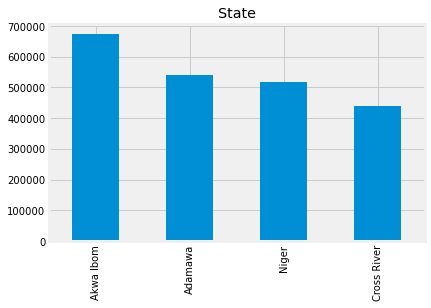

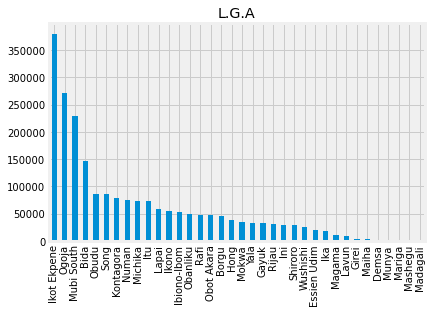

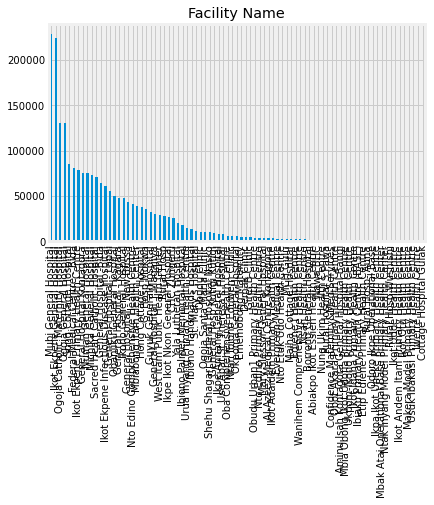

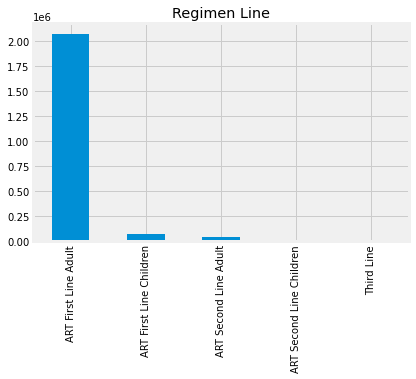

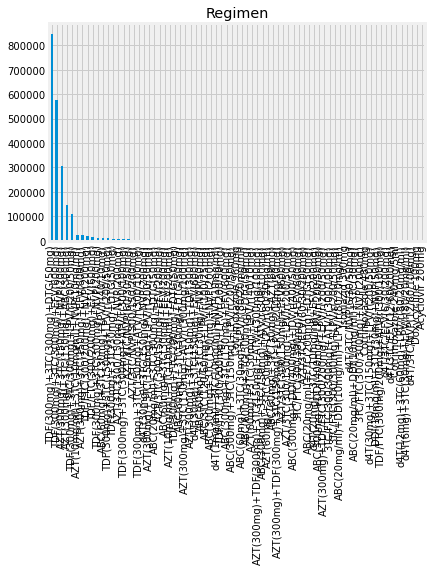

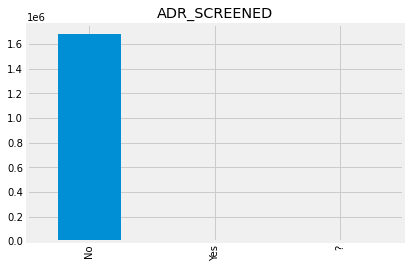

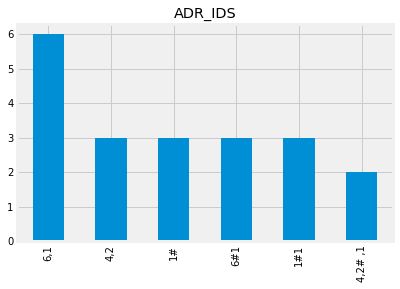

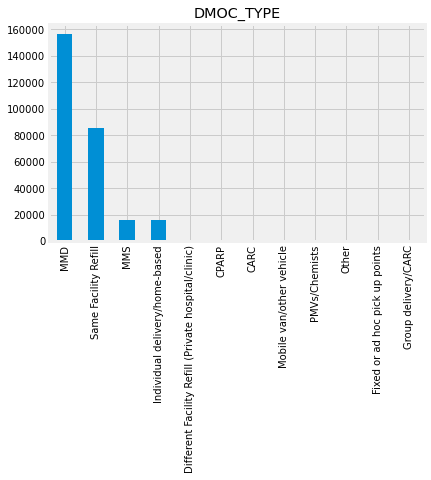

/anaconda/envs/py38_default/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)


KeyboardInterrupt: 

In [32]:
#categorical_bar_plot(df)

In [33]:
# remove visits with null values
df = df[~df['DATE_VISIT'].isnull()]

print("df with all next appointments:",df.shape)
df.loc[df['NEXT_APPOINTMENT'].isnull(),'NEXT_APPOINTMENT'] = df.DATE_VISIT + timedelta(days=-1)
print("df with NULL next appointments filled:",df.shape)

df with all next appointments: (2173290, 49)
df with NULL next appointments filled: (2173290, 49)


In [34]:
print("PATIENT_ID count is: " + "{:,}".format(df.PATIENT_ID.nunique()))

PATIENT_ID count is: 81,352


# Data Transformation

## Data Deduplication

In [38]:
print(f"Before deduplication the dataframe has {df.shape[0]} rows")
print(" ")
df.drop_duplicates(subset=['PATIENT_ID','FACILITY_ID','ADHERENCE','DATE_VISIT','NEXT_APPOINTMENT','MORNING','AFTERNOON','EVENING'],inplace=True)
print(f"After deduplication the dataframe has {df.shape[0]} rows")

Before deduplication the dataframe has 2173290 rows
 
After deduplication the dataframe has 1163234 rows


In [ ]:
print(f"There are {df.loc[:, df.columns != 'PHARMACY_ID'].duplicated(subset=['PATIENT_ID','DATE_VISIT','NEXT_APPOINTMENT','DMOC_TYPE','DURATION','MORNING','AFTERNOON','EVENING','ADHERENCE']).sum()}")

In [39]:
print(f"Before secondary deduplication the dataframe has {df.shape[0]} rows")
print(" ")
df.drop_duplicates(subset=['PATIENT_ID','DATE_VISIT','NEXT_APPOINTMENT','Regimen'],inplace=True)
print(f"After deduplication the dataframe has {df.shape[0]} rows")

Before secondary deduplication the dataframe has 1163234 rows
 
After deduplication the dataframe has 766087 rows


## Stats on dates for IIT target definition

In [40]:
df['EF_DAYS_UNTIL_NEXT_APPOINTMENT'] = (df['NEXT_APPOINTMENT'] - df['DATE_VISIT']).dt.days
df['DIFFERENCE_DURATION_AND_DAYS_UNTIL_NEXT_APPOINTMENT'] = df['DURATION'] - df['EF_DAYS_UNTIL_NEXT_APPOINTMENT']

In [41]:
median_days_to_next_appointment = df['EF_DAYS_UNTIL_NEXT_APPOINTMENT'].median()
print("median_days_to_next_appointment:",median_days_to_next_appointment)

median_days_to_next_appointment: 57.0


In [ ]:
round(df.groupby(['EF_YEAR_DATE_VISIT','State'])['DURATION'].mean(),2)

## Date Featurization

In [42]:
df = visit_features.generate_date_features(df,'DATE_VISIT')
df = visit_features.generate_date_features(df,'NEXT_APPOINTMENT')
df = visit_features.generate_date_features(df,'EF_MEDS_CONSUMED_DATE')

Generating features for DATE_VISIT, starting with  rows:766,087; cols: 51
Generating features for DATE_VISIT,ending with  rows:766,087; cols: 63
Generating features for NEXT_APPOINTMENT, starting with  rows:766,087; cols: 63
Generating features for NEXT_APPOINTMENT,ending with  rows:766,087; cols: 75
Generating features for EF_MEDS_CONSUMED_DATE, starting with  rows:766,087; cols: 75
Generating features for EF_MEDS_CONSUMED_DATE,ending with  rows:766,087; cols: 87


In [43]:
# Get first date of visit
df['EF_FIRST_DATE_VISIT'] = df.groupby('PATIENT_ID')['DATE_VISIT'].transform('min')

# generate sequence based off patient ID
df['EF_ID_SEQUENCE'] = df.groupby('PATIENT_ID').cumcount() + 1

# Filter for Start
df = df.loc[(df['EF_FIRST_DATE_VISIT'] >= start_date)]
print("Shape after filtering early starters before: ", start_date, visit_features.format_shape(df))

Shape after filtering early starters before:  2010-01-01 00:00:00 rows:711,276; cols: 89


In [44]:
df['EF_MONTH_UNIQUE'] = df['EF_YEAR_DATE_VISIT'].apply(str)+'-'+df['EF_MONTH_DATE_VISIT'].apply(str)

<ipython-input-44-18a7447be832>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['EF_MONTH_UNIQUE'] = df['EF_YEAR_DATE_VISIT'].apply(str)+'-'+df['EF_MONTH_DATE_VISIT'].apply(str)


## Days since last visit

In [45]:
df = visit_features.days_months_since_visit_features(df)
df = df.rename(columns={'NEXT_APPOINTMENT': 'EF_NEXT_APPOINTMENT'})

/home/marang/jhup_rise/jhupiego_rise_phase1/002_EDA/hiv_support_package/visit_features.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['EF_LAST_VISIT_DATE'] = df.groupby(patient_id_col)[visit_date_col].shift(1)
/home/marang/jhup_rise/jhupiego_rise_phase1/002_EDA/hiv_support_package/visit_features.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['EF_LAST_VISIT_DATE'] = df['EF_LAST_VISIT_DATE'].fillna(df[visit_date_col])
/home/marang/jhup_rise/jhupiego_rise_phase1/002_EDA/hiv_support_package/vi

## Appointment Date Binning

In [46]:
bins_NextAppDays = [-100,-2,0,1,32,100,420,10000]
a = df['EF_DAYS_UNTIL_NEXT_APPOINTMENT'].value_counts(bins=bins_NextAppDays).sort_index()
b = df['EF_DAYS_UNTIL_NEXT_APPOINTMENT'].value_counts(bins=bins_NextAppDays, 
                                                          normalize=True).sort_index()
b = (b*100).round(0)
pd.concat([a,b], axis=1)

EF_DAYS_UNTIL_NEXT_APPOINTMENT  \
(-100.001, -2.0]                           73452   
(-2.0, 0.0]                                 4404   
(0.0, 1.0]                                  6772   
(1.0, 32.0]                               136446   
(32.0, 100.0]                             337639   
(100.0, 420.0]                            133060   
(420.0, 10000.0]                            3734   

                  EF_DAYS_UNTIL_NEXT_APPOINTMENT  
(-100.001, -2.0]                            10.0  
(-2.0, 0.0]                                  1.0  
(0.0, 1.0]                                   1.0  
(1.0, 32.0]                                 19.0  
(32.0, 100.0]                               47.0  
(100.0, 420.0]                              19.0  
(420.0, 10000.0]                             1.0

Large number of appointments have **"bad"** next appointment dates; Next Appointment Date is Before current Visit date.

In [47]:
print("All: "+ format(len(df.index), ','))

print("More than 1 days: "+ format(len(df[df['EF_DAYS_UNTIL_NEXT_APPOINTMENT'] > 1].index), ','))
print("More than 32 days: "+ format(len(df[df['EF_DAYS_UNTIL_NEXT_APPOINTMENT'] > 32].index), ','))
print("More than 100 days: "+ format(len(df[df['EF_DAYS_UNTIL_NEXT_APPOINTMENT'] > 100].index), ','))
print("More than 420 days: "+ format(len(df[df['EF_DAYS_UNTIL_NEXT_APPOINTMENT']> 420].index), ','))

print("Less than 1 days: "+ format(len(df[df['EF_DAYS_UNTIL_NEXT_APPOINTMENT'] < 1].index), ','))
print("Less than 10 days: "+ format(len(df[df['EF_DAYS_UNTIL_NEXT_APPOINTMENT'] < 10].index), ','))
print("Less than 32 days: "+ format(len(df[df['EF_DAYS_UNTIL_NEXT_APPOINTMENT'] < 32].index), ','))
print("Less than 100 days: "+ format(len(df[df['EF_DAYS_UNTIL_NEXT_APPOINTMENT'] < 100].index),','))
print("Less than 420 days: "+ format(len(df[df['EF_DAYS_UNTIL_NEXT_APPOINTMENT'] < 420].index),','))

All: 711,276
More than 1 days: 611,003
More than 32 days: 474,557
More than 100 days: 136,918
More than 420 days: 3,858
Less than 1 days: 93,501
Less than 10 days: 106,208
Less than 32 days: 232,680
Less than 100 days: 574,112
Less than 420 days: 707,271


In [48]:
print("All: "+ format(len(df.index), ','))

print("Less than -1 days: "+ format(len(df[df['EF_DAYS_UNTIL_NEXT_APPOINTMENT'] < -1].index), ','))
print("Less than -32 days: "+ format(len(df[df['EF_DAYS_UNTIL_NEXT_APPOINTMENT'] < -32].index), ','))
print("Less than -100 days: "+ format(len(df[df['EF_DAYS_UNTIL_NEXT_APPOINTMENT'] < -100].index), ','))
print("Less than -120 days: "+ format(len(df[df['EF_DAYS_UNTIL_NEXT_APPOINTMENT'] < -120].index), ','))
print("Less than -250 days: "+ format(len(df[df['EF_DAYS_UNTIL_NEXT_APPOINTMENT'] < -250].index), ','))
print("Less than -420 days: "+ format(len(df[df['EF_DAYS_UNTIL_NEXT_APPOINTMENT'] < -420].index), ','))

All: 711,276
Less than -1 days: 89,097
Less than -32 days: 56,338
Less than -100 days: 15,645
Less than -120 days: 12,876
Less than -250 days: 1,733
Less than -420 days: 236


## Medication Consumed date Analysis

In [49]:
bins_Duration = [-100,-2,0,1,32,100,420,10000]
a = df['DURATION'].value_counts(bins=bins_Duration).sort_index()
b = df['DURATION'].value_counts(bins=bins_Duration, 
                                                          normalize=True).sort_index()
b = (b*100).round(0)
pd.concat([a,b], axis=1)

DURATION  DURATION
(-100.001, -2.0]         0       0.0
(-2.0, 0.0]            268       0.0
(0.0, 1.0]             111       0.0
(1.0, 32.0]         208164      29.0
(32.0, 100.0]       407971      57.0
(100.0, 420.0]       94744      13.0
(420.0, 10000.0]        18       0.0

In [50]:
print("All: "+ format(len(df.index), ','))

print("More than 1 days: "+ format(len(df[df['DURATION'] < 1].index), ','))
print("More than 1 days: "+ format(len(df[df['DURATION'] > 1].index), ','))
print("More than 32 days: "+ format(len(df[df['DURATION'] > 32].index), ','))
print("More than 100 days: "+ format(len(df[df['DURATION'] > 100].index), ','))
print("More than 250 days: "+ format(len(df[df['DURATION'] > 250].index), ','))
print("More than 420 days: "+ format(len(df[df['DURATION']> 420].index), ','))

All: 711,276
More than 1 days: 268
More than 1 days: 710,897
More than 32 days: 502,733
More than 100 days: 94,762
More than 250 days: 812
More than 420 days: 18


### Outlier Filtration

In [40]:
# print("Incl. bad next appointment dates: "+ format(len(df.index), ','))
# # exclude outliers - more than 14 monthsprint("Exclude bad next appointment dates: "+ format(len(df.index), ','))
# df = df[(df['EF_DAYS_UNTIL_NEXT_APPOINTMENT'] > 1) & 
#         (df['EF_DAYS_UNTIL_NEXT_APPOINTMENT'] < 420)]

# print("Excl. bad next appointment dates: "+ format(len(df.index), ','))

Incl. bad next appointment dates: 1,580,306
Excl. bad next appointment dates: 1,371,042


In [51]:
round(df.groupby(['EF_YEAR_DATE_VISIT','State'])['DURATION'].mean(),2)

EF_YEAR_DATE_VISIT  State      
2010                Adamawa         42.58
                    Akwa Ibom       30.36
                    Cross River     34.70
                    Niger           38.78
2011                Adamawa         43.48
                    Akwa Ibom       28.45
                    Cross River     45.73
                    Niger           57.97
2012                Adamawa         41.54
                    Akwa Ibom       29.57
                    Cross River     59.10
                    Niger           58.57
2013                Adamawa         41.30
                    Akwa Ibom       28.43
                    Cross River     62.06
                    Niger           55.62
2014                Adamawa         44.89
                    Akwa Ibom       30.80
                    Cross River     57.88
                    Niger           56.67
2015                Adamawa         49.39
                    Akwa Ibom       32.31
                    Cross River     62.88
  

In [52]:
df = visit_features.next_actual_visit_features(df)

# Target Creation

In [42]:
## Calculate cl
df = target_creation.missed_visit_target(df,LAST_EXPECTED_VISIT)
df = target_creation.next_visit_target(df,LAST_EXPECTED_VISIT)
df = target_creation.last_visit_target(df,LAST_EXPECTED_VISIT)
df = target_creation.rise_missed_visit_target(df,LAST_EXPECTED_VISIT)

In [43]:
df['T_IS_LAST_VISIT'].value_counts(normalize=True)

False    0.96244
True     0.03756
Name: T_IS_LAST_VISIT, dtype: float64

## Days between Next Appointment and Actual

In [44]:
print('EF_DAYS_BETWEEN_NEXT_APPOINTMENT_AND_ACTUAL_VISIT_DATE')
display('mean ', df['EF_DAYS_BETWEEN_NEXT_APPOINTMENT_AND_ACTUAL_VISIT_DATE'].mean(),
            'median', df['EF_DAYS_BETWEEN_NEXT_APPOINTMENT_AND_ACTUAL_VISIT_DATE'].median())

EF_DAYS_BETWEEN_NEXT_APPOINTMENT_AND_ACTUAL_VISIT_DATE


'mean '

Timedelta('-73 days +09:55:04.467201773')

'median'

Timedelta('-56 days +00:00:00')

In [45]:
df[df['EF_DAYS_BETWEEN_NEXT_APPOINTMENT_AND_ACTUAL_VISIT_DATE'] > np.timedelta64(0, 'D')]['EF_DAYS_BETWEEN_NEXT_APPOINTMENT_AND_ACTUAL_VISIT_DATE'].median()

Timedelta('43 days 00:00:00')

In [48]:
df = visit_features.days_late_features(df)
display_cols = ['DATE_VISIT','EF_NEXT_APPOINTMENT', 
#                  'EF_DAYS_UNTIL_NEXT_APPOINTMENT',
                 'EF_NEXT_ACTUAL_VISIT_DATE', 
                 'EF_DAYS_BETWEEN_NEXT_APPOINTMENT_AND_ACTUAL_VISIT_DATE', 
                 'T_MISSED_NEXT_VISIT_28','T_MISSED_NEXT_VISIT_28_RISE','EF_WAS_MORE_THAN_3_DAYS_LATE','EF_WAS_MORE_THAN_28_DAYS_LATE',
                 'EF_WAS_MORE_THAN_60_DAYS_LATE','EF_WAS_MORE_THAN_90_DAYS_LATE'#, 'EF_THIS_VISIT_WAS_MISSED'
               ]

In [49]:
df['EF_LATE_THIS_VISIT'] = df['EF_DAYS_LATE'].dt.days>0
dist = df['EF_DAYS_BETWEEN_NEXT_APPOINTMENT_AND_ACTUAL_VISIT_DATE'
  ].dt.days.sort_values().value_counts(normalize=True, bins=[-400,-20,0,30,90,3000]).sort_index()
print(dist)
print(df['EF_LATE_THIS_VISIT'].value_counts(normalize=True))

(-400.001, -20.0]    0.696844
(-20.0, 0.0]         0.089157
(0.0, 30.0]          0.057282
(30.0, 90.0]         0.024815
(90.0, 3000.0]       0.049852
Name: EF_DAYS_BETWEEN_NEXT_APPOINTMENT_AND_ACTUAL_VISIT_DATE, dtype: float64
False    0.868051
True     0.131949
Name: EF_LATE_THIS_VISIT, dtype: float64


In [119]:
check = df['EF_DAYS_BETWEEN_MEDS_CONSUMED_AND_ACTUAL_VISIT_DATE'
  ].dt.days.sort_values().value_counts(normalize=True, bins=[-400,-20,0,30,90,3000]).sort_index()
print(check)


(-400.001, -20.0]    0.706514
(-20.0, 0.0]         0.075498
(0.0, 30.0]          0.061348
(30.0, 90.0]         0.024664
(90.0, 3000.0]       0.054572
Name: EF_DAYS_BETWEEN_MEDS_CONSUMED_AND_ACTUAL_VISIT_DATE, dtype: float64


In [50]:
df = visit_features.late_last_visit_feature(df)

In [52]:
print("start 3 days late count & ratio")
df = visit_features.late_days_count_ratio_features(df, 3,'PATIENT_ID')
df = visit_features.late_days_count_ratio_features(df, 28,'PATIENT_ID')
df = visit_features.late_days_count_ratio_features(df, 60,'PATIENT_ID')
!date

start 3 days late count & ratio
Mon Jul 19 06:06:18 UTC 2021


### Facility Features

In [54]:
df['EF_FACILITY_ID'] = df['FACILITY_ID']

In [55]:
df = visit_features.create_last_facility_codes_EF(df,'PATIENT_ID')

In [57]:
df['EF_VISITS_AT_THIS_FACILITY'] = df.groupby(['PATIENT_ID','Facility Name'])['PHARMACY_ID'].cumcount()+1

In [58]:
df = visit_features.months_first_visit_features(df)

In [59]:
df = df.rename(columns={'EF_DAYOFMONTH_DATE_VISIT': 'EF_DAY_OF_MONTH_VISIT_DATE', 
                        'EF_DAYOFWEEK_DATE_VISIT': 'EF_DAY_OF_WEEK_VISIT_DATE'})

# LTFU Rate

## LTFU Pepfar

In [61]:
ltfu_rates = df.groupby(['EF_YEAR_DATE_VISIT','EF_MONTH_DATE_VISIT','EF_SEASON_DATE_VISIT','EF_QUARTER_DATE_VISIT','State'])['T_MISSED_NEXT_VISIT_28'].value_counts(normalize=True).sort_index()
ltfu_rates = ltfu_rates.rename('LTFU_RATE')
ltfu_rates = ltfu_rates.reset_index()
ltfu_rates['LTFU_RATES_PERCENTAGE'] = 100.*ltfu_rates['LTFU_RATE'] 

In [62]:
print("summary of monthly ltfu_rate over all months: ")
print(" ")
print(ltfu_rates[ltfu_rates['T_MISSED_NEXT_VISIT_28']==1][[
    'EF_YEAR_DATE_VISIT','EF_SEASON_DATE_VISIT','EF_QUARTER_DATE_VISIT', 'EF_MONTH_DATE_VISIT', 'LTFU_RATE','LTFU_RATES_PERCENTAGE']].describe())

summary of monthly ltfu_rate over all months: 
 
       EF_YEAR_DATE_VISIT  EF_SEASON_DATE_VISIT  EF_QUARTER_DATE_VISIT  \
count          378.000000            378.000000              378.00000   
mean          2017.460317              2.481481                2.47619   
std              1.694041              1.116990                1.11213   
min           2015.000000              1.000000                1.00000   
25%           2016.000000              1.000000                1.00000   
50%           2017.000000              2.000000                2.00000   
75%           2019.000000              3.000000                3.00000   
max           2020.000000              4.000000                4.00000   

       EF_MONTH_DATE_VISIT   LTFU_RATE  LTFU_RATES_PERCENTAGE  
count           378.000000  378.000000             378.000000  
mean              6.666667    0.151579              15.157948  
std               3.422503    0.096244               9.624439  
min               1.000000  

## JHPIEGO RISE

In [63]:
rise_ltfu_rates = df.groupby(['EF_YEAR_DATE_VISIT','EF_MONTH_DATE_VISIT','EF_SEASON_DATE_VISIT','EF_QUARTER_DATE_VISIT','State'])['T_MISSED_NEXT_VISIT_28_RISE'].value_counts(normalize=True).sort_index()
rise_ltfu_rates = rise_ltfu_rates.rename('LTFU_RATE')
rise_ltfu_rates = rise_ltfu_rates.reset_index()
rise_ltfu_rates['LTFU_RATES_PERCENTAGE'] = 100.*rise_ltfu_rates['LTFU_RATE'] 

## Summary statistics

### Pepfar

In [65]:
df_ltfu = ltfu_rates[ltfu_rates['T_MISSED_NEXT_VISIT_28']==1][[
    'State','EF_YEAR_DATE_VISIT', 'EF_SEASON_DATE_VISIT','EF_QUARTER_DATE_VISIT', 'EF_MONTH_DATE_VISIT', 'LTFU_RATE','LTFU_RATES_PERCENTAGE']]

In [66]:
df_ltfu_not = ltfu_rates[ltfu_rates['T_MISSED_NEXT_VISIT_28']==0][[
    'State','EF_YEAR_DATE_VISIT', 'EF_SEASON_DATE_VISIT','EF_QUARTER_DATE_VISIT', 'EF_MONTH_DATE_VISIT', 'LTFU_RATE','LTFU_RATES_PERCENTAGE']]

In [67]:
df_ltfu_state_mean = round(df_ltfu.groupby('State')['LTFU_RATES_PERCENTAGE'].mean(),2)
df_ltfu_state_median = round(df_ltfu.groupby('State')['LTFU_RATES_PERCENTAGE'].median(),2)
df_ltfu_year_mean = round(df_ltfu.groupby('EF_YEAR_DATE_VISIT')['LTFU_RATES_PERCENTAGE'].mean(),2)
df_ltfu_year_median = round(df_ltfu.groupby('EF_YEAR_DATE_VISIT')['LTFU_RATES_PERCENTAGE'].median(),2)
df_ltfu_quarter_mean = round(df_ltfu.groupby('EF_QUARTER_DATE_VISIT')['LTFU_RATES_PERCENTAGE'].mean(),2)
df_ltfu_quarter_median = round(df_ltfu.groupby('EF_QUARTER_DATE_VISIT')['LTFU_RATES_PERCENTAGE'].median(),2)
df_ltfu_season_mean = round(df_ltfu.groupby('EF_SEASON_DATE_VISIT')['LTFU_RATES_PERCENTAGE'].mean(),2)
df_ltfu_season_median = round(df_ltfu.groupby('EF_SEASON_DATE_VISIT')['LTFU_RATES_PERCENTAGE'].median(),2)

In [68]:
df_ltfu_state_mean = df_ltfu_state_mean.rename('AVG_LTFU_RATE')
df_ltfu_state_mean=df_ltfu_state_mean.reset_index()
df_ltfu_state_mean

State  AVG_LTFU_RATE
0      Adamawa           8.37
1    Akwa Ibom          19.74
2  Cross River           8.66
3        Niger          23.72

In [69]:
df_ltfu_year_mean = df_ltfu_year_mean.rename('AVG_LTFU_RATE')
df_ltfu_year_mean=df_ltfu_year_mean.reset_index()
df_ltfu_year_mean

EF_YEAR_DATE_VISIT  AVG_LTFU_RATE
0                2015          22.70
1                2016          19.52
2                2017          16.36
3                2018          14.82
4                2019          11.34
5                2020           5.28

In [70]:
df_ltfu_quarter_mean = df_ltfu_quarter_mean.rename('AVG_LTFU_RATE')
df_ltfu_quarter_mean=df_ltfu_quarter_mean.reset_index()
df_ltfu_quarter_mean

EF_QUARTER_DATE_VISIT  AVG_LTFU_RATE
0                      1          16.35
1                      2          15.35
2                      3          14.66
3                      4          14.22

In [71]:
df_ltfu_season_mean = df_ltfu_season_mean.rename('AVG_LTFU_RATE')
df_ltfu_season_mean = df_ltfu_season_mean.reset_index()

In [72]:
df_ltfu_season_mean['EF_SEASON_DATE_VISIT'] = df_ltfu_season_mean['EF_SEASON_DATE_VISIT'].map({1: 'Spring',2:'Summer',3:'Autumn',4:'Winter'})
df_ltfu_season_mean

EF_SEASON_DATE_VISIT  AVG_LTFU_RATE
0               Spring          15.56
1               Summer          15.08
2               Autumn          13.88
3               Winter          16.12

### RISE

In [73]:
df_ltfu_rise = rise_ltfu_rates[rise_ltfu_rates['T_MISSED_NEXT_VISIT_28_RISE']==1][[
    'State','EF_YEAR_DATE_VISIT', 'EF_SEASON_DATE_VISIT','EF_QUARTER_DATE_VISIT', 'EF_MONTH_DATE_VISIT', 'LTFU_RATE','LTFU_RATES_PERCENTAGE']]

In [74]:
df_ltfu_rise_not = rise_ltfu_rates[rise_ltfu_rates['T_MISSED_NEXT_VISIT_28_RISE']==0][[
    'State','EF_YEAR_DATE_VISIT', 'EF_SEASON_DATE_VISIT','EF_QUARTER_DATE_VISIT', 'EF_MONTH_DATE_VISIT', 'LTFU_RATE','LTFU_RATES_PERCENTAGE']]

In [75]:
df_ltfu_rise_state_mean = round(df_ltfu_rise.groupby('State')['LTFU_RATES_PERCENTAGE'].mean(),2)
df_ltfu_rise_state_median = round(df_ltfu_rise.groupby('State')['LTFU_RATES_PERCENTAGE'].median(),2)
df_ltfu_rise_year_mean = round(df_ltfu_rise.groupby('EF_YEAR_DATE_VISIT')['LTFU_RATES_PERCENTAGE'].mean(),2)
df_ltfu_rise_year_median = round(df_ltfu_rise.groupby('EF_YEAR_DATE_VISIT')['LTFU_RATES_PERCENTAGE'].median(),2)
df_ltfu_rise_quarter_mean = round(df_ltfu_rise.groupby('EF_QUARTER_DATE_VISIT')['LTFU_RATES_PERCENTAGE'].mean(),2)
df_ltfu_rise_quarter_median = round(df_ltfu_rise.groupby('EF_QUARTER_DATE_VISIT')['LTFU_RATES_PERCENTAGE'].median(),2)
df_ltfu_rise_season_mean = round(df_ltfu_rise.groupby('EF_SEASON_DATE_VISIT')['LTFU_RATES_PERCENTAGE'].mean(),2)
df_ltfu_rise_season_median = round(df_ltfu_rise.groupby('EF_SEASON_DATE_VISIT')['LTFU_RATES_PERCENTAGE'].median(),2)

In [76]:
df_ltfu_rise_state_mean = df_ltfu_rise_state_mean.rename('AVG_LTFU_RATE')
df_ltfu_rise_state_mean=df_ltfu_rise_state_mean.reset_index()
df_ltfu_rise_state_mean

State  AVG_LTFU_RATE
0      Adamawa           8.66
1    Akwa Ibom          21.58
2  Cross River           8.65
3        Niger          24.54

In [77]:
df_ltfu_rise_year_mean = df_ltfu_rise_year_mean.rename('AVG_LTFU_RATE')
df_ltfu_rise_year_mean=df_ltfu_rise_year_mean.reset_index()
df_ltfu_rise_year_mean

EF_YEAR_DATE_VISIT  AVG_LTFU_RATE
0                2015          23.56
1                2016          20.50
2                2017          16.96
3                2018          15.42
4                2019          11.93
5                2020           5.87

In [78]:
df_ltfu_rise_quarter_mean = df_ltfu_rise_quarter_mean.rename('AVG_LTFU_RATE')
df_ltfu_rise_quarter_mean=df_ltfu_rise_quarter_mean.reset_index()
df_ltfu_rise_quarter_mean

EF_QUARTER_DATE_VISIT  AVG_LTFU_RATE
0                      1          17.36
1                      2          16.05
2                      3          15.11
3                      4          14.88

In [79]:
df_ltfu_rise_season_mean = df_ltfu_rise_season_mean.rename('AVG_LTFU_RATE')
df_ltfu_rise_season_mean = df_ltfu_rise_season_mean.reset_index()

In [80]:
df_ltfu_rise_season_mean['EF_SEASON_DATE_VISIT'] = df_ltfu_rise_season_mean['EF_SEASON_DATE_VISIT'].map({1: 'Spring',2:'Summer',3:'Autumn',4:'Winter'})

In [81]:
df_ltfu_rise_season_mean

EF_SEASON_DATE_VISIT  AVG_LTFU_RATE
0               Spring          16.29
1               Summer          15.53
2               Autumn          14.46
3               Winter          17.20

In [191]:
df[['EF_DAYS_UNTIL_NEXT_APPOINTMENT','DIFFERENCE_DURATION_AND_DAYS_UNTIL_NEXT_APPOINTMENT','DATE_VISIT','EF_MEDS_CONSUMED_DATE','NEXT_APPOINTMENT','DURATION']].sample(10)

EF_DAYS_UNTIL_NEXT_APPOINTMENT  \
1384877                            28.0   
719482                            234.0   
905397                             89.0   
654884                             27.0   
618724                             57.0   
462869                             60.0   
3046098                            33.0   
2788880                            59.0   
2337463                           170.0   
629070                           -181.0   

         DIFFERENCE_DURATION_AND_DAYS_UNTIL_NEXT_APPOINTMENT DATE_VISIT  \
1384877                                                2.0   2016-08-17   
719482                                              -204.0   2019-06-12   
905397                                                 1.0   2020-10-19   
654884                                                 3.0   2018-10-18   
618724                                                 3.0   2019-10-24   
462869                                                 0.0   2013-10-22   
3046098                                               27.0   2017-08-03   
2788880                                               61.0   2017-08-07   
2337463                                               10.0   2020-11-09   
629070                                               241.0   2018-12-04   

        EF_MEDS_CONSUMED_DATE NEXT_APPOINTMENT  DURATION  
1384877            2016-09-16       2016-09-14        30  
719482             2019-07-12       2020-02-01        30  
905397             2021-01-17       2021-01-16        90  
654884             2018-11-17       2018-11-14        30  
618724             2019-12-23       2019-12-20        60  
462869             2013-12-21       2013-12-21        60  
3046098            2017-10-02       2017-09-05        60  
2788880            2017-12-05       2017-10-05       120  
2337463            2021-05-08       2021-04-28       180  
629070             2019-02-02       2018-06-06        60

# Plots

## Yearly Trends

### Pepfar

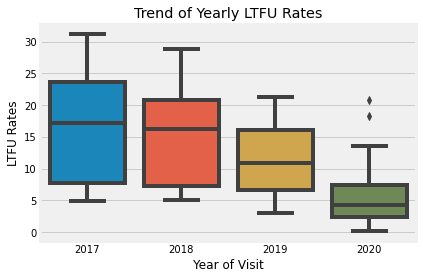

In [82]:
ax = sns.boxplot(x="EF_YEAR_DATE_VISIT",y="LTFU_RATES_PERCENTAGE",data=df_ltfu[(df_ltfu['EF_YEAR_DATE_VISIT'] > 2016) & (df_ltfu['EF_YEAR_DATE_VISIT'] < 2021)])
ax.set(xlabel='Year of Visit', ylabel='LTFU Rates')
ax.set_title('Trend of Yearly LTFU Rates')
sns.set(rc={'figure.figsize':(8,8)})

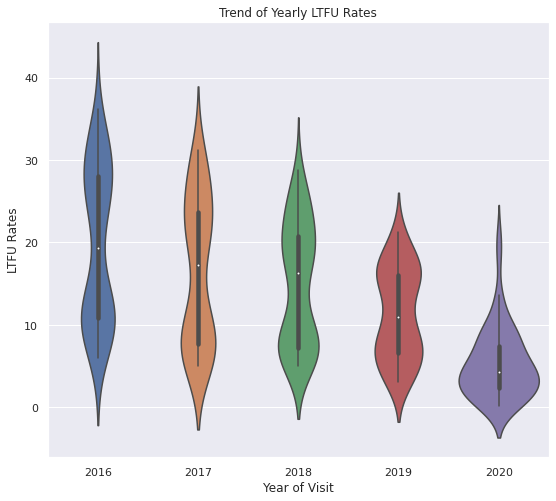

In [83]:
ax = sns.violinplot(x="EF_YEAR_DATE_VISIT",y="LTFU_RATES_PERCENTAGE",data=df_ltfu[(df_ltfu['EF_YEAR_DATE_VISIT'] > 2015) & (df_ltfu['EF_YEAR_DATE_VISIT'] < 2021)])
ax.set(xlabel='Year of Visit', ylabel='LTFU Rates')
ax.set_title('Trend of Yearly LTFU Rates')
sns.set(rc={'figure.figsize':(8,8)})

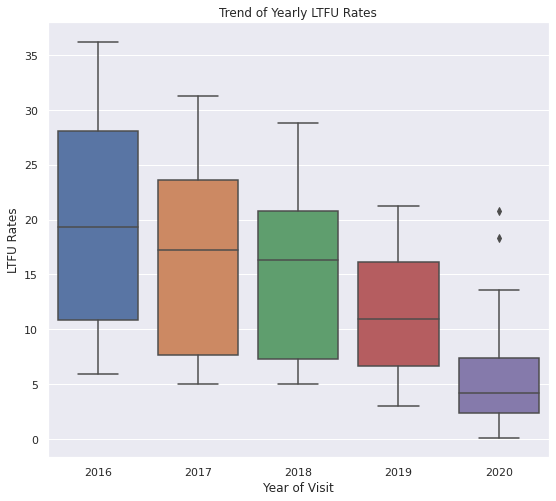

In [84]:
ax = sns.boxplot(x="EF_YEAR_DATE_VISIT",y="LTFU_RATES_PERCENTAGE",data=df_ltfu[df_ltfu['EF_YEAR_DATE_VISIT'] > 2015])
ax.set(xlabel='Year of Visit', ylabel='LTFU Rates')
ax.set_title('Trend of Yearly LTFU Rates')
sns.set(rc={'figure.figsize':(8,8)})

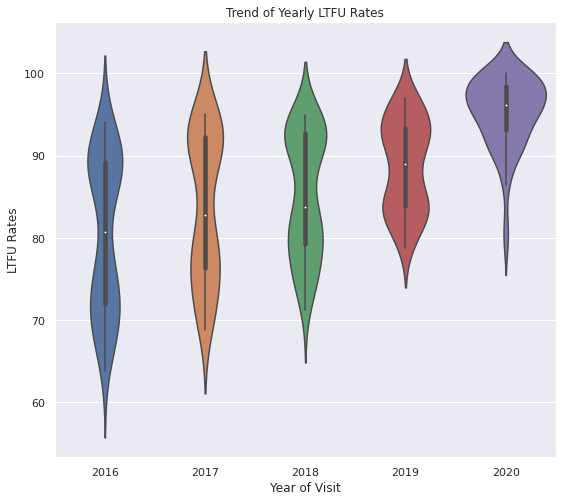

In [85]:
ax = sns.violinplot(x="EF_YEAR_DATE_VISIT",y="LTFU_RATES_PERCENTAGE",data=df_ltfu_not[df_ltfu_not['EF_YEAR_DATE_VISIT'] > 2015])
ax.set(xlabel='Year of Visit', ylabel='LTFU Rates')
ax.set_title('Trend of Yearly LTFU Rates')
sns.set(rc={'figure.figsize':(8,8)})

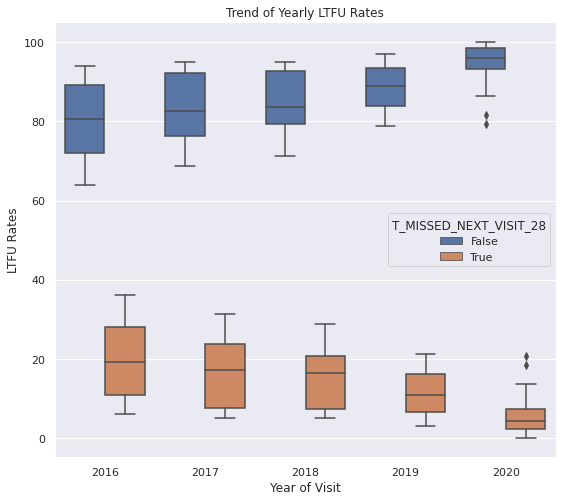

In [86]:
ax = sns.boxplot(x="EF_YEAR_DATE_VISIT",y="LTFU_RATES_PERCENTAGE",data=ltfu_rates[ltfu_rates['EF_YEAR_DATE_VISIT'] > 2015],hue="T_MISSED_NEXT_VISIT_28")
ax.set(xlabel='Year of Visit', ylabel='LTFU Rates')
ax.set_title('Trend of Yearly LTFU Rates')
sns.set(rc={'figure.figsize':(8,8)})

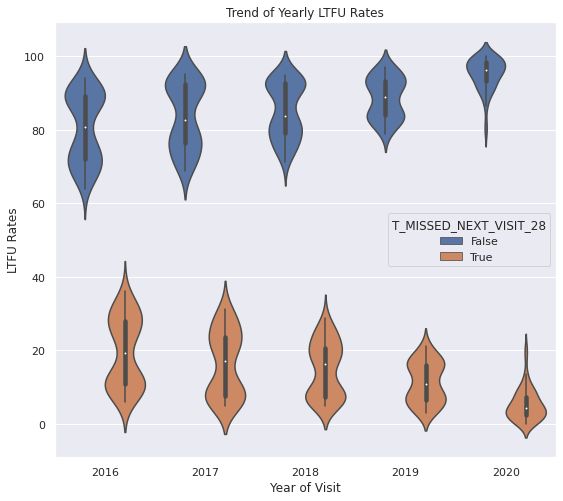

In [87]:
ax = sns.violinplot(x="EF_YEAR_DATE_VISIT",y="LTFU_RATES_PERCENTAGE",data=ltfu_rates[ltfu_rates['EF_YEAR_DATE_VISIT'] > 2015],hue="T_MISSED_NEXT_VISIT_28")
ax.set(xlabel='Year of Visit', ylabel='LTFU Rates')
ax.set_title('Trend of Yearly LTFU Rates')
sns.set(rc={'figure.figsize':(8,8)})

### RISE

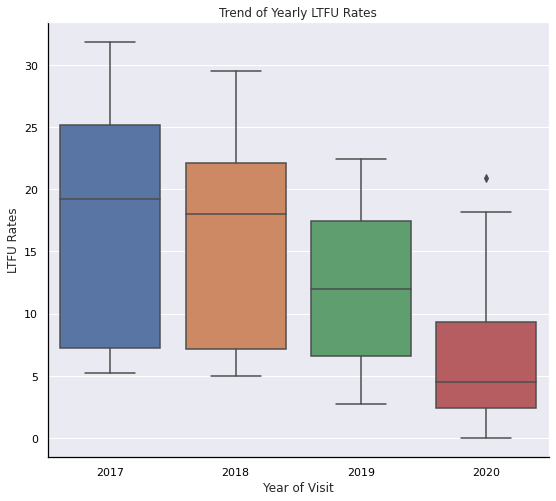

In [186]:
ax = sns.boxplot(x="EF_YEAR_DATE_VISIT",y="LTFU_RATES_PERCENTAGE",data=df_ltfu_rise[(df_ltfu_rise['EF_YEAR_DATE_VISIT'] > 2016) & (df_ltfu_rise['EF_YEAR_DATE_VISIT'] < 2021)])
ax.set(xlabel='Year of Visit', ylabel='LTFU Rates')
ax.set_title('Trend of Yearly LTFU Rates')
sns.set(rc={'figure.figsize':(8,8)})
ax.set_frame_on(True)
plt.box(True)
ax.spines['bottom'].set_color('black')
# ax.spines['top'].set_color('black') 
# ax.spines['right'].set_color('black')
ax.tick_params(axis='x', colors='black')
ax.tick_params(axis='y', colors='black')
ax.spines['left'].set_color('black')
plt.savefig("../Figures/yearly_rise_ltfu_rates.png", transparent=True)

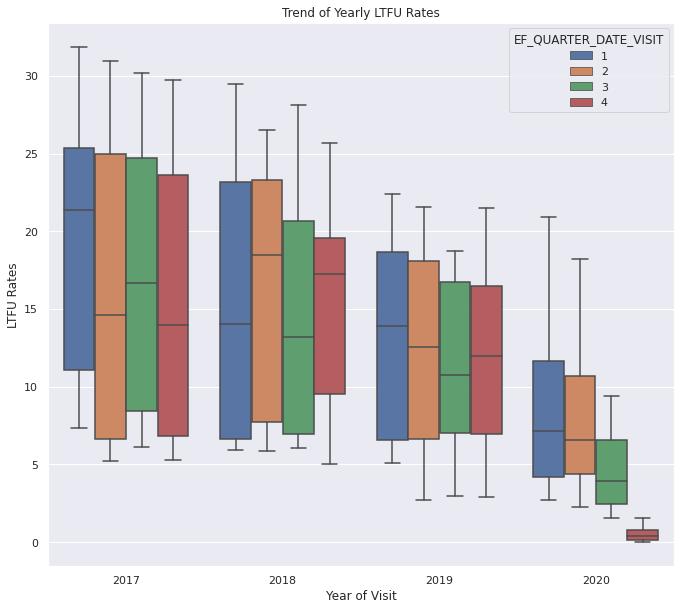

In [103]:
ax = sns.boxplot(x="EF_YEAR_DATE_VISIT",y="LTFU_RATES_PERCENTAGE",data=df_ltfu_rise[(df_ltfu_rise['EF_YEAR_DATE_VISIT'] > 2016) & (df_ltfu_rise['EF_YEAR_DATE_VISIT'] < 2021)],hue="EF_QUARTER_DATE_VISIT")
ax.set(xlabel='Year of Visit', ylabel='LTFU Rates')
ax.set_title('Trend of Yearly LTFU Rates')
sns.set(rc={'figure.figsize':(8,8)})

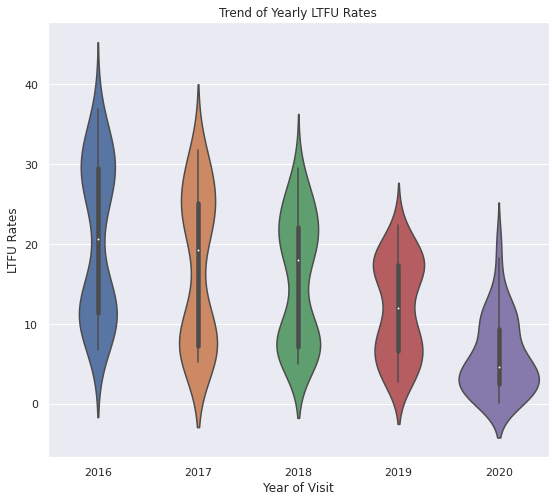

In [89]:
ax = sns.violinplot(x="EF_YEAR_DATE_VISIT",y="LTFU_RATES_PERCENTAGE",data=df_ltfu_rise[(df_ltfu_rise['EF_YEAR_DATE_VISIT'] > 2015) & (df_ltfu_rise['EF_YEAR_DATE_VISIT'] < 2021)])
ax.set(xlabel='Year of Visit', ylabel='LTFU Rates')
ax.set_title('Trend of Yearly LTFU Rates')
sns.set(rc={'figure.figsize':(8,8)})

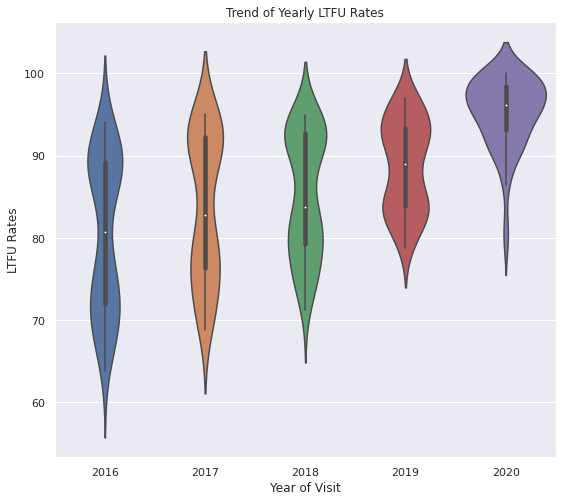

In [90]:
ax = sns.violinplot(x="EF_YEAR_DATE_VISIT",y="LTFU_RATES_PERCENTAGE",data=df_ltfu_not[df_ltfu_not['EF_YEAR_DATE_VISIT'] > 2015])
ax.set(xlabel='Year of Visit', ylabel='LTFU Rates')
ax.set_title('Trend of Yearly LTFU Rates')
sns.set(rc={'figure.figsize':(8,8)})

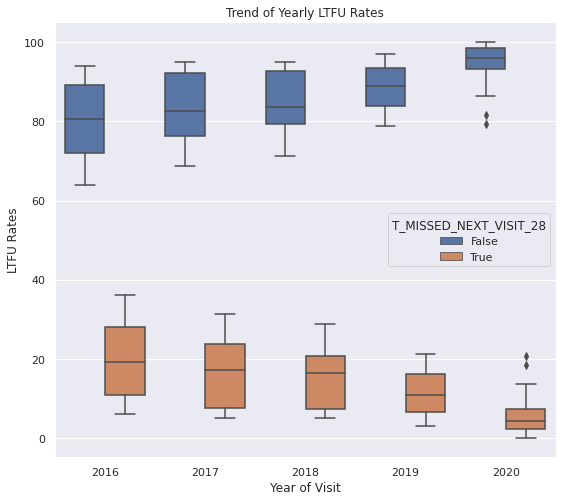

In [91]:
ax = sns.boxplot(x="EF_YEAR_DATE_VISIT",y="LTFU_RATES_PERCENTAGE",data=ltfu_rates[ltfu_rates['EF_YEAR_DATE_VISIT'] > 2015],hue="T_MISSED_NEXT_VISIT_28")
ax.set(xlabel='Year of Visit', ylabel='LTFU Rates')
ax.set_title('Trend of Yearly LTFU Rates')
sns.set(rc={'figure.figsize':(8,8)})

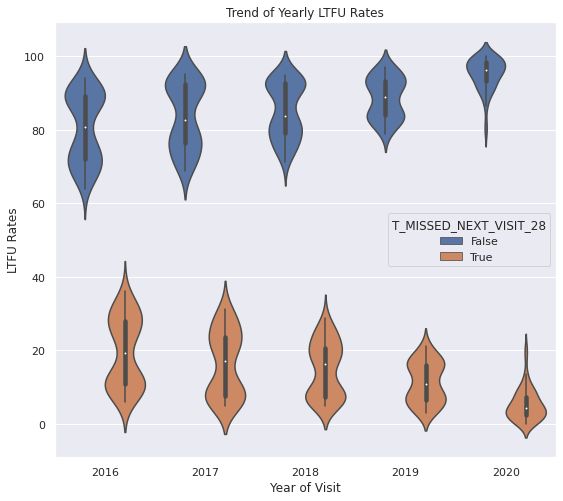

In [92]:
ax = sns.violinplot(x="EF_YEAR_DATE_VISIT",y="LTFU_RATES_PERCENTAGE",data=ltfu_rates[ltfu_rates['EF_YEAR_DATE_VISIT'] > 2015],hue="T_MISSED_NEXT_VISIT_28")
ax.set(xlabel='Year of Visit', ylabel='LTFU Rates')
ax.set_title('Trend of Yearly LTFU Rates')
sns.set(rc={'figure.figsize':(8,8)})

## Geographical Trend

### Pepfar

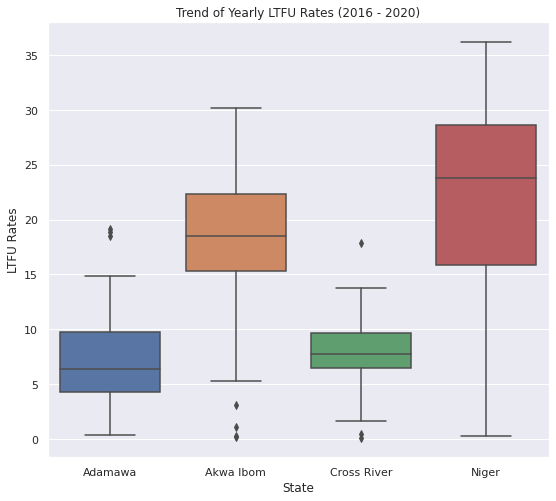

In [93]:
ax = sns.boxplot(x="State",y="LTFU_RATES_PERCENTAGE",data=df_ltfu[(df_ltfu['EF_YEAR_DATE_VISIT'] > 2015) & (df_ltfu['EF_YEAR_DATE_VISIT'] < 2021)])
ax.set(xlabel='State', ylabel='LTFU Rates')
ax.set_title('Trend of Yearly LTFU Rates (2016 - 2020)')
sns.set(rc={'figure.figsize':(8,8)})

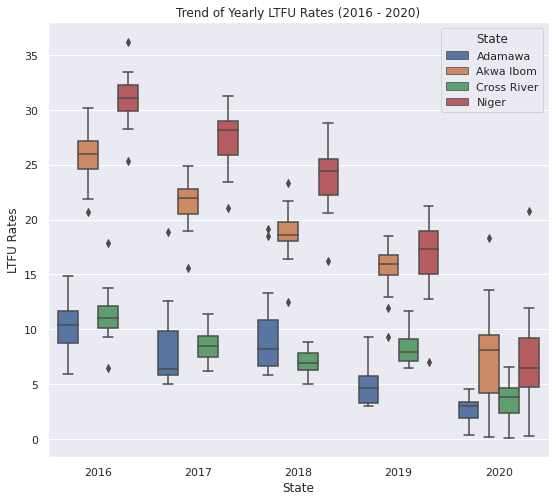

In [104]:
ax = sns.boxplot(x="EF_YEAR_DATE_VISIT",y="LTFU_RATES_PERCENTAGE",data=df_ltfu[(df_ltfu['EF_YEAR_DATE_VISIT'] > 2015) & (df_ltfu['EF_YEAR_DATE_VISIT'] < 2021)],hue="State")
ax.set(xlabel='State', ylabel='LTFU Rates')
ax.set_title('Trend of Yearly LTFU Rates (2016 - 2020)')
sns.set(rc={'figure.figsize':(8,8)})

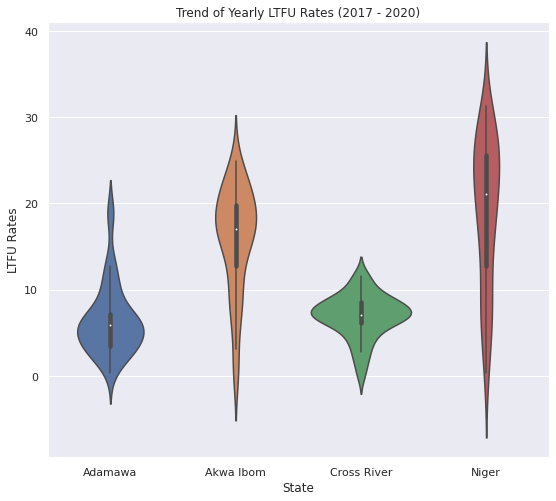

In [94]:
ax = sns.violinplot(x="State",y="LTFU_RATES_PERCENTAGE",data=df_ltfu[(df_ltfu['EF_YEAR_DATE_VISIT'] > 2016) & (df_ltfu['EF_YEAR_DATE_VISIT'] < 2021)])
ax.set(xlabel='State', ylabel='LTFU Rates')
ax.set_title('Trend of Yearly LTFU Rates (2017 - 2020)')
sns.set(rc={'figure.figsize':(8,8)})

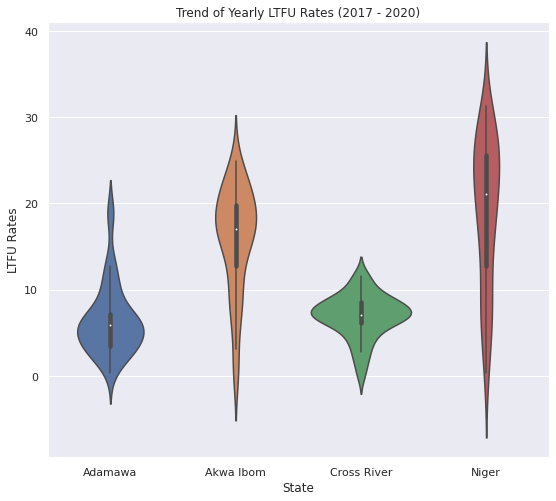

In [95]:
ax = sns.violinplot(x="State",y="LTFU_RATES_PERCENTAGE",data=df_ltfu[(df_ltfu['EF_YEAR_DATE_VISIT'] > 2016) & (df_ltfu['EF_YEAR_DATE_VISIT'] < 2021)])
ax.set(xlabel='State', ylabel='LTFU Rates')
ax.set_title('Trend of Yearly LTFU Rates (2017 - 2020)')
sns.set(rc={'figure.figsize':(8,8)})

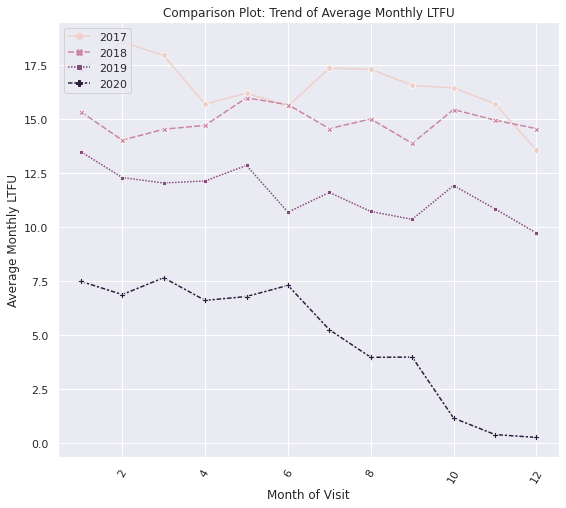

In [96]:
ax_viral = sns.lineplot(x = 'EF_MONTH_DATE_VISIT',y='LTFU_RATES_PERCENTAGE',data=df_ltfu[(df_ltfu['EF_YEAR_DATE_VISIT'] > 2016) & (df_ltfu['EF_YEAR_DATE_VISIT'] < 2021)],hue='EF_YEAR_DATE_VISIT',markers=True,err_style="bars",ci=None,style="EF_YEAR_DATE_VISIT")
ax_viral.set(xlabel='Month of Visit', ylabel='Average Monthly LTFU')
ax_viral.set_title('Comparison Plot: Trend of Average Monthly LTFU')
plt.xticks(rotation=60)
plt.legend(loc='upper left')
sns.set(rc={'figure.figsize':(10,10)})

### RISE

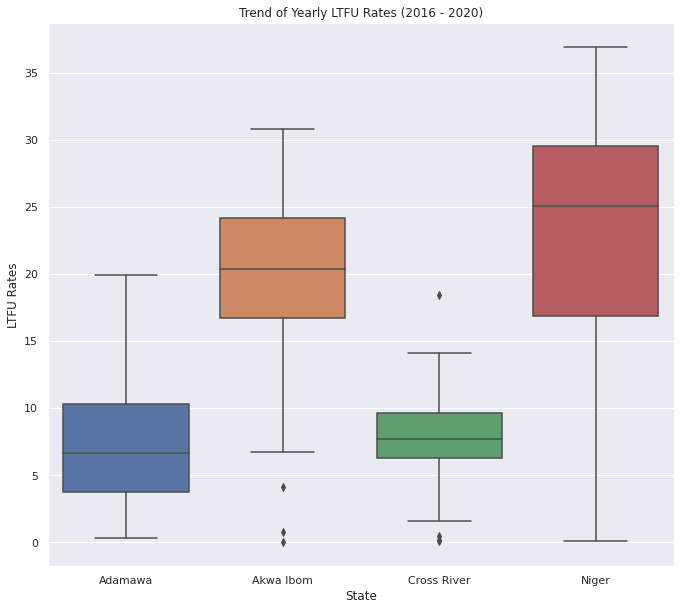

In [97]:
ax = sns.boxplot(x="State",y="LTFU_RATES_PERCENTAGE",data=df_ltfu_rise[(df_ltfu_rise['EF_YEAR_DATE_VISIT'] > 2015) & (df_ltfu_rise['EF_YEAR_DATE_VISIT'] < 2021)])
ax.set(xlabel='State', ylabel='LTFU Rates')
ax.set_title('Trend of Yearly LTFU Rates (2016 - 2020)')
sns.set(rc={'figure.figsize':(8,8)})

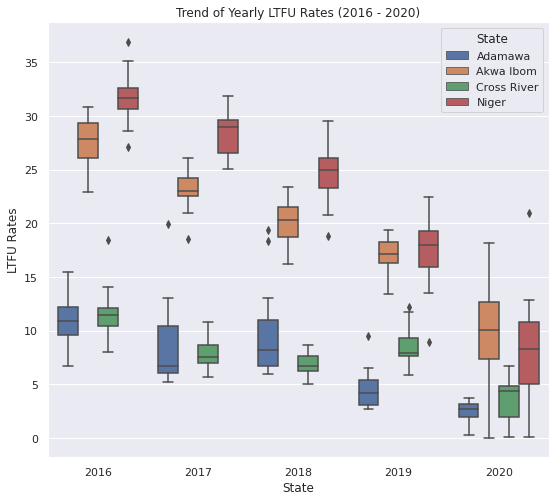

In [105]:
ax = sns.boxplot(x="EF_YEAR_DATE_VISIT",y="LTFU_RATES_PERCENTAGE",data=df_ltfu_rise[(df_ltfu_rise['EF_YEAR_DATE_VISIT'] > 2015) & (df_ltfu_rise['EF_YEAR_DATE_VISIT'] < 2021)],hue="State")
ax.set(xlabel='State', ylabel='LTFU Rates')
ax.set_title('Trend of Yearly LTFU Rates (2016 - 2020)')
sns.set(rc={'figure.figsize':(8,8)})

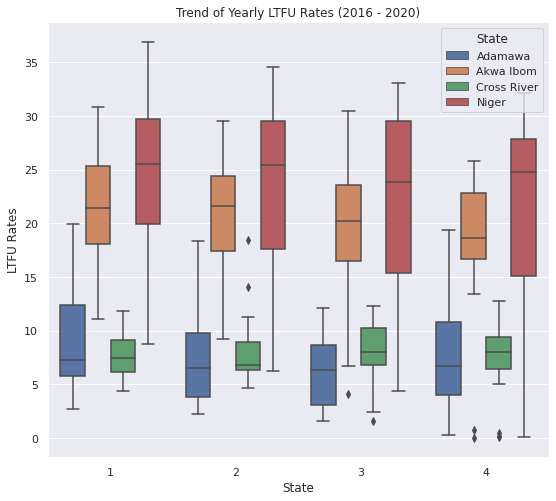

In [106]:
ax = sns.boxplot(x="EF_QUARTER_DATE_VISIT",y="LTFU_RATES_PERCENTAGE",data=df_ltfu_rise[(df_ltfu_rise['EF_YEAR_DATE_VISIT'] > 2015) & (df_ltfu_rise['EF_YEAR_DATE_VISIT'] < 2021)],hue="State")
ax.set(xlabel='State', ylabel='LTFU Rates')
ax.set_title('Trend of Yearly LTFU Rates (2016 - 2020)')
sns.set(rc={'figure.figsize':(8,8)})

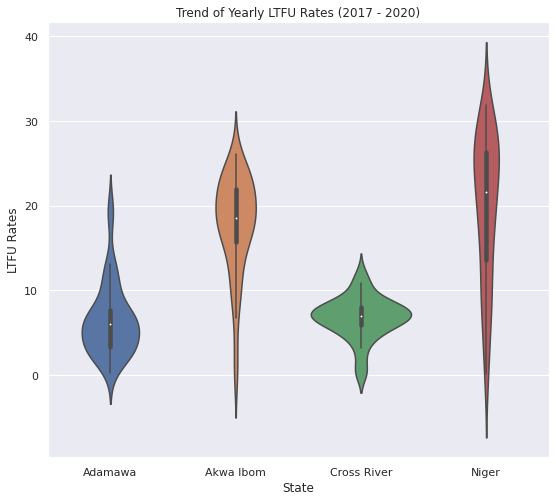

In [98]:
ax = sns.violinplot(x="State",y="LTFU_RATES_PERCENTAGE",data=df_ltfu_rise[(df_ltfu_rise['EF_YEAR_DATE_VISIT'] > 2016) & (df_ltfu_rise['EF_YEAR_DATE_VISIT'] < 2021)])
ax.set(xlabel='State', ylabel='LTFU Rates')
ax.set_title('Trend of Yearly LTFU Rates (2017 - 2020)')
sns.set(rc={'figure.figsize':(8,8)})

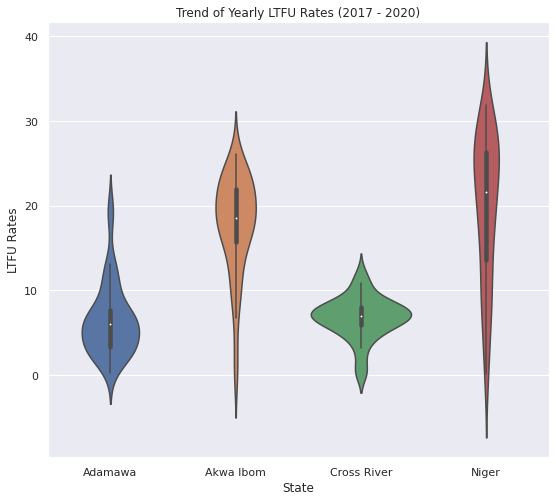

In [99]:
ax = sns.violinplot(x="State",y="LTFU_RATES_PERCENTAGE",data=df_ltfu_rise[(df_ltfu_rise['EF_YEAR_DATE_VISIT'] > 2016) & (df_ltfu_rise['EF_YEAR_DATE_VISIT'] < 2021)])
ax.set(xlabel='State', ylabel='LTFU Rates')
ax.set_title('Trend of Yearly LTFU Rates (2017 - 2020)')
sns.set(rc={'figure.figsize':(8,8)})

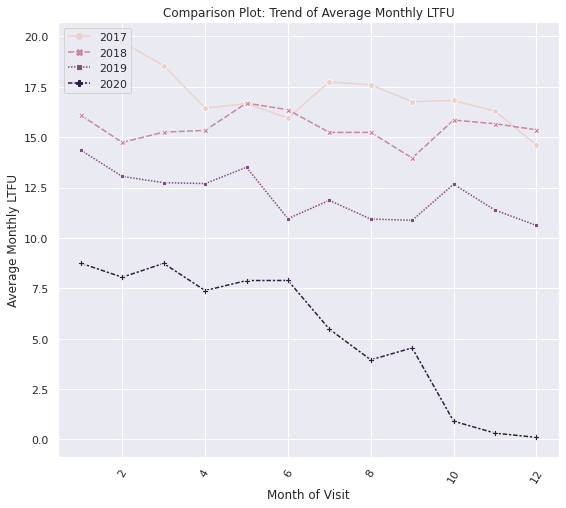

In [100]:
ax_viral = sns.lineplot(x = 'EF_MONTH_DATE_VISIT',y='LTFU_RATES_PERCENTAGE',data=df_ltfu_rise[(df_ltfu_rise['EF_YEAR_DATE_VISIT'] > 2016) & (df_ltfu_rise['EF_YEAR_DATE_VISIT'] < 2021)],hue='EF_YEAR_DATE_VISIT',markers=True,err_style="bars",ci=None,style="EF_YEAR_DATE_VISIT")
ax_viral.set(xlabel='Month of Visit', ylabel='Average Monthly LTFU')
ax_viral.set_title('Comparison Plot: Trend of Average Monthly LTFU')
plt.xticks(rotation=60)
plt.legend(loc='upper left')
sns.set(rc={'figure.figsize':(10,10)})

# Base Line Rate

In [116]:
days_7 = round(df[df["T_MISSED_NEXT_VISIT_7"] == True].shape[0] / df.shape[0] * 100, 2)
days_28 = round(df[df["T_MISSED_NEXT_VISIT_28"] == True].shape[0] / df.shape[0] * 100, 2)
days_60 = round(df[df["T_MISSED_NEXT_VISIT_60"] == True].shape[0] / df.shape[0] * 100, 2)
days_90 = round(df[df["T_MISSED_NEXT_VISIT_90"] == True].shape[0] / df.shape[0] * 100, 2)
print(f"> 7 days late: {days_7}%\n> 28 days late: {days_28}%")
print(f"> 60 days Late: {days_60}%\n> 90 days late: {days_90}%")

> 7 days late: 13.03%
> 28 days late: 10.7%
> 60 days Late: 9.02%
> 90 days late: 8.06%


In [117]:
days_7 = round(df[df["T_MISSED_NEXT_VISIT_7_RISE"] == True].shape[0] / df.shape[0] * 100, 2)
days_28 = round(df[df["T_MISSED_NEXT_VISIT_28_RISE"] == True].shape[0] / df.shape[0] * 100, 2)
days_60 = round(df[df["T_MISSED_NEXT_VISIT_60_RISE"] == True].shape[0] / df.shape[0] * 100, 2)
days_90 = round(df[df["T_MISSED_NEXT_VISIT_90_RISE"] == True].shape[0] / df.shape[0] * 100, 2)
print(f"> 7 days late: {days_7}%\n> 28 days late: {days_28}%")
print(f"> 60 days Late: {days_60}%\n> 90 days late: {days_90}%")

> 7 days late: 13.69%
> 28 days late: 11.34%
> 60 days Late: 9.55%
> 90 days late: 8.65%


## In depth Analysis